# Protein–DNA ΔΔG: Neural Network (MLP) Walkthrough

This notebook builds a **Neural Network baseline** using scikit-learn's `MLPRegressor`.
It mirrors the Random Forest tutorial structure but adds NN-specific steps like scaling,
early stopping, and training/validation loss curves.

**Pipeline outline**
1. Load & audit data (`rawdat.csv` + `exp_data_all.csv`).
2. Merge on `SEQUENCE_ID`, align `LABEL_COL`.
3. EDA: missingness, duplicates, dtypes, quick stats.
4. Define features/target and standardize inputs.
5. Train/validation split and **5-fold cross-validation** with a `Pipeline`.
6. Fit a **baseline MLPRegressor** with **early stopping**.
7. Evaluate (R², RMSE, MAE) on hold-out test set.
8. Inspect training curves, cross-validated predictions.
9. Model interpretation: **Permutation Importance** and **PDP**.
10. Quick **RandomizedSearchCV** for better hyperparameters.
11. Save artifacts (model, metrics, predictions, config).


## 0. Setup & Configuration

Adjust paths if your repo layout differs.


In [2]:
# --- Python stdlib ---
import os, math, json
from pathlib import Path

# --- Data stack ---
import numpy as np
import pandas as pd

# --- scikit-learn ---
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, RandomizedSearchCV, learning_curve
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# --- Utils ---
import joblib
import matplotlib.pyplot as plt

# Reproducibility
RANDOM_STATE = 42

# -------- Project paths (Path objects only) --------
PROJECT_ROOT = Path.cwd()          # or Path('.'), but keep as Path
INPUTS_DIR   = PROJECT_ROOT
OUTPUT_DIR   = PROJECT_ROOT / "ML_NN_CV"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# -------- Column identifiers --------
SEQUENCE_ID = "sequence"    # Unique key across files
LABEL_COL   = "bind_avg"    # ΔΔG label

# -------- Input files (Path objects) --------
FEATURE_FILES  = [INPUTS_DIR / "rawdat.csv"]        # list in case you add more later
REFERENCE_FILE = INPUTS_DIR / "exp_data_all.csv"

print(f"Inputs dir: {INPUTS_DIR}")
print(f"Outputs dir: {OUTPUT_DIR}")
print(f"Feature file(s): {FEATURE_FILES}")
print(f"Reference file: {REFERENCE_FILE}")


Inputs dir: /Users/nakku/Desktop/ML-Protein-DNA-Binding-Affinity/ML-Protein-DNA-Binding-Affinity/tutorial notebooks
Outputs dir: /Users/nakku/Desktop/ML-Protein-DNA-Binding-Affinity/ML-Protein-DNA-Binding-Affinity/tutorial notebooks/ML_NN_CV
Feature file(s): [PosixPath('/Users/nakku/Desktop/ML-Protein-DNA-Binding-Affinity/ML-Protein-DNA-Binding-Affinity/tutorial notebooks/rawdat.csv')]
Reference file: /Users/nakku/Desktop/ML-Protein-DNA-Binding-Affinity/ML-Protein-DNA-Binding-Affinity/tutorial notebooks/exp_data_all.csv


In [3]:
# Load feature data
features = pd.read_csv(FEATURE_FILES[0])
features[SEQUENCE_ID] = features[SEQUENCE_ID].str.replace("MycMax_", "", regex=False)

# Load reference labels
labels = pd.read_csv(REFERENCE_FILE)

# Merge
df = pd.merge(features, labels, on=SEQUENCE_ID, how="inner")
df = df.dropna(subset=[LABEL_COL])
print("Data shape:", df.shape)
df.head()


Data shape: (68040, 13)


,sequence,run,VDWAALS,EEL,EGB,ESURF,HB Energy,Hydrophobic Energy,Pi-Pi Energy,Delta_Entropy,bind_avg,binding_type,improving
0,CAGGGCTGGGTCCACCTCATGGCCTTTGTTCTGGAA,9,-236.997,-1869.660,1823.216,-35.292,-2.590101,-156.445725,-4.282747,-24.750849,0.166339,1,0
1,CAGGGCTGGGTCCACCTCATGGCCTTTGTTCTGGAA,9,-218.620,-1850.331,1807.831,-32.521,-2.977171,-142.709472,-7.240534,-25.235404,0.166339,1,0
2,CAGGGCTGGGTCCACCTCATGGCCTTTGTTCTGGAA,9,-232.611,-1878.075,1834.181,-34.170,-3.105868,-145.088977,-8.856276,-25.124940,0.166339,1,0
3,CAGGGCTGGGTCCACCTCATGGCCTTTGTTCTGGAA,9,-203.677,-1870.595,1823.641,-32.402,-3.414769,-150.961716,-5.338670,-23.079573,0.166339,1,0
4,CAGGGCTGGGTCCACCTCATGGCCTTTGTTCTGGAA,9,-212.279,-1864.730,1820.462,-31.858,-3.571942,-146.583284,-7.171679,-22.812241,0.166339,1,0


## 2. Quick Data Audit

We check:
- dtypes and info
- missing values per column
- duplicate sequences (leakage risk)
- quick numeric stats


In [5]:
print("\nDataFrame info:")
df.info()

print("\nMissing values per column (top 20):")
missing = df.isna().sum().sort_values(ascending=False)
display(missing.head(20))

dup_count = df.duplicated(subset=[SEQUENCE_ID]).sum()
print(f"\nDuplicate {SEQUENCE_ID} rows:", dup_count)

print("\nDescriptive stats (numeric):")
display(df.describe().T.head(15))



DataFrame info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 68040 entries, 0 to 68039
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sequence            68040 non-null  object 
 1   run                 68040 non-null  int64  
 2   VDWAALS             68040 non-null  float64
 3   EEL                 68040 non-null  float64
 4   EGB                 68040 non-null  float64
 5   ESURF               68040 non-null  float64
 6   HB Energy           68040 non-null  float64
 7   Hydrophobic Energy  68040 non-null  float64
 8   Pi-Pi Energy        68040 non-null  float64
 9   Delta_Entropy       68040 non-null  float64
 10  bind_avg            68040 non-null  float64
 11  binding_type        68040 non-null  int64  
 12  improving           68040 non-null  int64  
dtypes: float64(9), int64(3), object(1)
memory usage: 7.3+ MB

Missing values per column (top 20):


sequence              0
run                   0
VDWAALS               0
EEL                   0
EGB                   0
ESURF                 0
HB Energy             0
Hydrophobic Energy    0
Pi-Pi Energy          0
Delta_Entropy         0
bind_avg              0
binding_type          0
improving             0
dtype: int64


Duplicate sequence rows: 67998

Descriptive stats (numeric):


,count,mean,std,min,25%,50%,75%,max
run,68040.0,10.500000,5.766324,1.000000,5.750000,10.500000,15.250000,20.000000
VDWAALS,68040.0,-201.378166,20.130228,-270.351000,-215.101000,-201.824000,-188.088000,-105.281000
EEL,68040.0,-1898.996636,38.450855,-2076.822000,-1924.672000,-1897.880000,-1873.026000,-1758.701000
EGB,68040.0,1850.679788,35.684319,1722.168000,1826.616000,1849.566000,1874.488000,2013.174000
ESURF,68040.0,-31.474066,2.393914,-43.027000,-33.082000,-31.535000,-29.954000,-18.292000
HB Energy,68040.0,-8.175591,6.065805,-30.470945,-13.585766,-4.378422,-3.275576,-0.324696
Hydrophobic Energy,68040.0,-135.669642,13.021100,-181.225207,-144.756364,-136.267018,-127.247098,-65.594027
Pi-Pi Energy,68040.0,-3.219995,2.584144,-17.248618,-4.999256,-2.974733,-0.964479,0.000000
Delta_Entropy,68040.0,-21.768632,2.156622,-33.004332,-23.182778,-21.798697,-20.392486,-9.803474
bind_avg,68040.0,0.182705,0.834584,-0.862667,-0.511587,-0.027842,0.614097,2.035660


## 3. Define Features & Target

We keep only **numeric** features (NN needs numeric inputs).  
We **do not** scale the label here (ΔΔG is in its physical units).  
Feature scaling will be handled in a `Pipeline` via `StandardScaler`.


In [6]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_cols if c != LABEL_COL]

X = df[feature_cols].copy()
y = df[LABEL_COL].copy()

print("Number of features:", len(feature_cols))
print("X shape:", X.shape, "| y shape:", y.shape)

# Drop constant columns (harmless but can slow training)
const_cols = [c for c in feature_cols if X[c].nunique(dropna=False) <= 1]
if const_cols:
    print("Dropping constant columns:", const_cols)
    X = X.drop(columns=const_cols)
    feature_cols = [c for c in feature_cols if c not in const_cols]

print("Final feature count:", len(feature_cols))


Number of features: 11
X shape: (68040, 11) | y shape: (68040,)
Final feature count: 11


But in this formulation we also too the 'binding_type' and 'improving' columns as our features which we don't want since they are a form of label, not a feature that we train our ML model on.

In [8]:
# Explicit denylist of non-features / potential leakage columns
LEAKAGE_COLS = {
    SEQUENCE_ID,   # identifier
    LABEL_COL,     # the true label ΔΔG
    'binding_type',
    'improving',
    # add others here if you discover more helper/label-like columns
}

# Identify numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove label/ID/leakage columns from features
feature_cols = [c for c in numeric_cols if c not in LEAKAGE_COLS]

# Build X/y
X = df[feature_cols].copy()
y = df[LABEL_COL].copy()

print("Dropped (non-feature) columns that were excluded:", sorted(list(set(LEAKAGE_COLS) & set(df.columns))))
print("Number of features:", len(feature_cols))
print("X shape:", X.shape, "| y shape:", y.shape)

# Drop constant columns (can add noise / slow training)
const_cols = [c for c in feature_cols if X[c].nunique(dropna=False) <= 1]
if const_cols:
    print("Dropping constant columns:", const_cols)
    X = X.drop(columns=const_cols)
    feature_cols = [c for c in feature_cols if c not in const_cols]

print("Final feature count:", len(feature_cols))


Dropped (non-feature) columns that were excluded: ['bind_avg', 'binding_type', 'improving', 'sequence']
Number of features: 9
X shape: (68040, 9) | y shape: (68040,)
Final feature count: 9


### Leakage guard

Sanity checks to ensure no leakage columns sneak into `X`.


In [9]:
leaky_in_X = sorted(list(set(['binding_type','improving', LABEL_COL, SEQUENCE_ID]) & set(X.columns)))
assert len(leaky_in_X) == 0, f"Leakage detected in features: {leaky_in_X}"
print("Leakage guard passed ✅  (no forbidden columns in X)")


Leakage guard passed ✅  (no forbidden columns in X)


## 4. Train/Test Split (80/20)

We keep a **hold-out** test set for honest final evaluation.


In [10]:
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, df[SEQUENCE_ID], test_size=0.2, random_state=RANDOM_STATE
)

print("Train:", X_train.shape, "Test:", X_test.shape)

# Save which sequences were in which split (traceability)
split_path = OUTPUT_DIR / 'split_indices.csv'
pd.DataFrame({SEQUENCE_ID: pd.concat([idx_train, idx_test]),
              'split': ['train']*len(idx_train) + ['test']*len(idx_test)}).to_csv(split_path, index=False)
print("Saved split indices ->", split_path)


Train: (54432, 9) Test: (13608, 9)
Saved split indices -> /Users/nakku/Desktop/ML-Protein-DNA-Binding-Affinity/ML-Protein-DNA-Binding-Affinity/tutorial notebooks/ML_NN_CV/split_indices.csv


## 5. Sanity Baseline (Mean Predictor)

A naive baseline that predicts the **training mean** of ΔΔG for all test samples.  
This gives a floorline to beat.


In [11]:
y_mean = np.full_like(y_test, fill_value=y_train.mean(), dtype=float)
baseline_r2  = r2_score(y_test, y_mean)
baseline_rmse = math.sqrt(mean_squared_error(y_test, y_mean))
baseline_mae  = mean_absolute_error(y_test, y_mean)

print(f"Baseline — R²: {baseline_r2:.4f} | RMSE: {baseline_rmse:.4f} | MAE: {baseline_mae:.4f}")


Baseline — R²: -0.0000 | RMSE: 0.8333 | MAE: 0.6773


## 6. Neural Network Pipeline

We use a `Pipeline` so scaling happens **inside CV** (no leakage).  
Baseline hyperparameters (good starting point):  
- hidden_layer_sizes: (128, 64)  
- activation: relu  
- solver: adam  
- alpha (L2): 1e-4  
- batch_size: 64  
- learning_rate_init: 1e-3  
- early_stopping: True (uses an internal validation split)  
- max_iter: 500, n_iter_no_change: 20  


In [12]:
mlp = MLPRegressor(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    alpha=1e-4,
    batch_size=64,
    learning_rate_init=1e-3,
    early_stopping=True,           # enables validation set inside fit
    n_iter_no_change=20,
    max_iter=500,
    random_state=RANDOM_STATE
)

pipeline = Pipeline(steps=[
    ('scaler', StandardScaler(with_mean=True, with_std=True)),
    ('mlp', mlp)
])

kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# Cross-validated metrics
cv_r2  = cross_val_score(pipeline, X, y, cv=kf, scoring='r2', n_jobs=-1)
cv_mse = cross_val_score(pipeline, X, y, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
cv_mae = cross_val_score(pipeline, X, y, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)

print("CV R²:", cv_r2, "\nMean R²:", cv_r2.mean())
print("\nCV RMSE:", np.sqrt(-cv_mse), "\nMean RMSE:", np.sqrt(-cv_mse).mean())
print("\nCV MAE:", -cv_mae, "\nMean MAE:", (-cv_mae).mean())


CV R²: [0.20587775 0.19050352 0.19154033] 
Mean R²: 0.1959738653614145

CV RMSE: [0.74617902 0.75103323 0.7477344 ] 
Mean RMSE: 0.7483155493296639

CV MAE: [0.59100038 0.59536908 0.59212023] 
Mean MAE: 0.5928298944927696


## 7. Fit on Train, Evaluate on Test

Train the NN pipeline and report **R², RMSE, MAE** on the hold-out test set.
We also save predictions for downstream use.


In [13]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

test_r2   = r2_score(y_test, y_pred)
test_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
test_mae  = mean_absolute_error(y_test, y_pred)

print(f"Test — R²: {test_r2:.4f} | RMSE: {test_rmse:.4f} | MAE: {test_mae:.4f}")

pred_df = pd.DataFrame({
    SEQUENCE_ID: idx_test.reset_index(drop=True),
    'y_true': y_test.reset_index(drop=True),
    'y_pred': pd.Series(y_pred)
})
pred_path = OUTPUT_DIR / 'nn_predictions.csv'
pred_df.to_csv(pred_path, index=False)
print("Saved predictions ->", pred_path)


Test — R²: 0.2098 | RMSE: 0.7408 | MAE: 0.5851
Saved predictions -> /Users/nakku/Desktop/ML-Protein-DNA-Binding-Affinity/ML-Protein-DNA-Binding-Affinity/tutorial notebooks/ML_NN_CV/nn_predictions.csv


## 8. Training & Validation Curves

Plot the **training loss** and, if `early_stopping=True`, the **validation score** per epoch.  
This helps diagnose under/overfitting and learning rate issues.


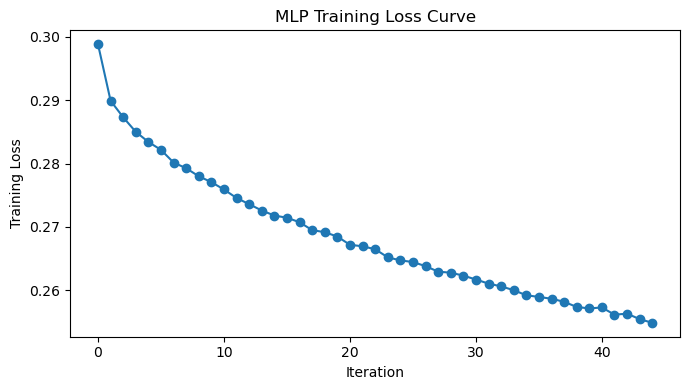

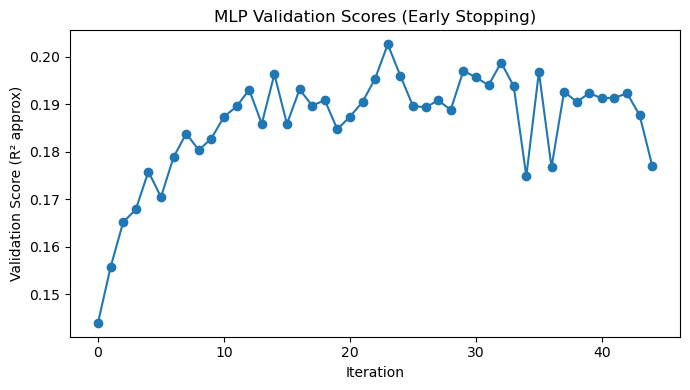

In [14]:
mlp_fitted = pipeline.named_steps['mlp']
# Training loss over iterations
plt.figure(figsize=(7,4))
plt.plot(mlp_fitted.loss_curve_, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Training Loss")
plt.title("MLP Training Loss Curve")
plt.tight_layout()
plt.show()

# Validation scores available when early_stopping=True (higher is better)
if hasattr(mlp_fitted, 'validation_scores_') and mlp_fitted.validation_scores_:
    plt.figure(figsize=(7,4))
    plt.plot(mlp_fitted.validation_scores_, marker='o')
    plt.xlabel("Iteration")
    plt.ylabel("Validation Score (R² approx)")
    plt.title("MLP Validation Scores (Early Stopping)")
    plt.tight_layout()
    plt.show()
else:
    print("No validation_scores_ available (set early_stopping=True to enable).")


## 9. Prediction Scatter & Residuals

Two diagnostics:
- **True vs Predicted** ΔΔG scatter with identity line.  
- **Residuals vs Predicted** to check systematic bias.


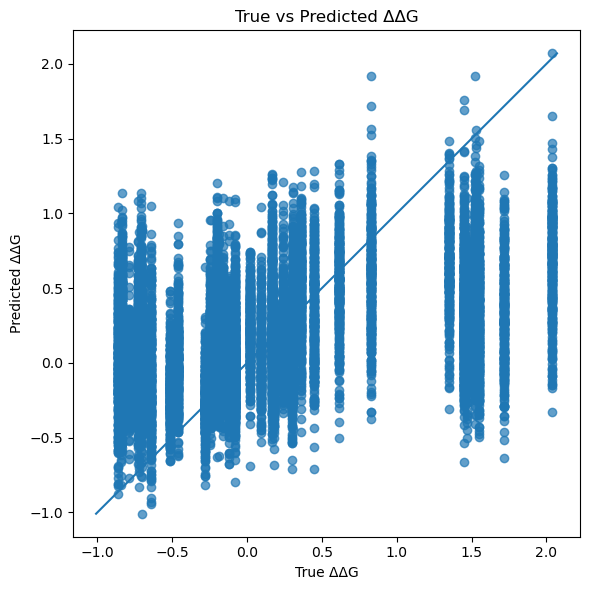

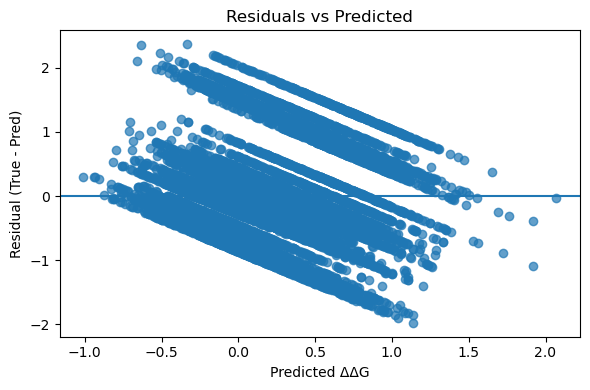

In [15]:
# 1) y_true vs y_pred
plt.figure(figsize=(6,6))
plt.scatter(pred_df['y_true'], pred_df['y_pred'], alpha=0.7)
minv, maxv = pred_df[['y_true','y_pred']].min().min(), pred_df[['y_true','y_pred']].max().max()
plt.plot([minv, maxv], [minv, maxv])
plt.xlabel("True ΔΔG")
plt.ylabel("Predicted ΔΔG")
plt.title("True vs Predicted ΔΔG")
plt.tight_layout()
plt.show()

# 2) Residual plot
residuals = pred_df['y_true'] - pred_df['y_pred']
plt.figure(figsize=(6,4))
plt.scatter(pred_df['y_pred'], residuals, alpha=0.7)
plt.axhline(0)
plt.xlabel("Predicted ΔΔG")
plt.ylabel("Residual (True - Pred)")
plt.title("Residuals vs Predicted")
plt.tight_layout()
plt.show()


## 10. Cross-validated Predictions (OOF)

Use `cross_val_predict` to get **out-of-fold** predictions for every sample, then compute global metrics.


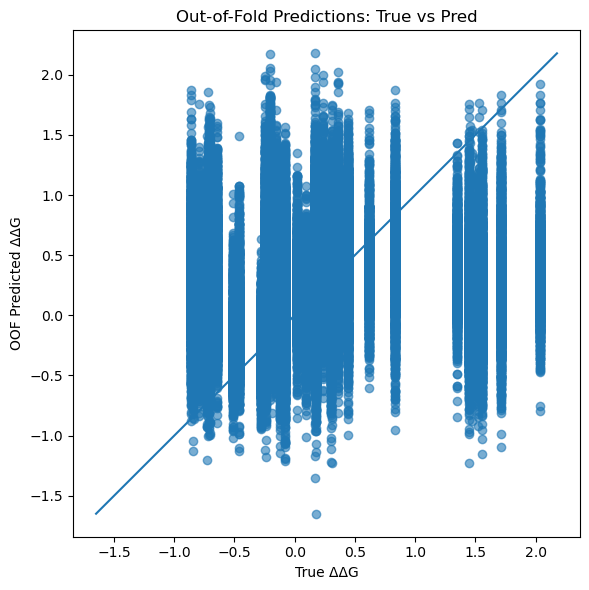

OOF — R²: -0.1813 | RMSE: 0.9071 | MAE: 0.7363


In [16]:
oof_pred = cross_val_predict(pipeline, X, y, cv=5, n_jobs=-1)

plt.figure(figsize=(6,6))
plt.scatter(y, oof_pred, alpha=0.6)
minv, maxv = min(y.min(), oof_pred.min()), max(y.max(), oof_pred.max())
plt.plot([minv, maxv], [minv, maxv])
plt.xlabel("True ΔΔG")
plt.ylabel("OOF Predicted ΔΔG")
plt.title("Out-of-Fold Predictions: True vs Pred")
plt.tight_layout()
plt.show()

oof_r2 = r2_score(y, oof_pred)
oof_rmse = math.sqrt(mean_squared_error(y, oof_pred))
oof_mae = mean_absolute_error(y, oof_pred)
print(f"OOF — R²: {oof_r2:.4f} | RMSE: {oof_rmse:.4f} | MAE: {oof_mae:.4f}")


## 11. Learning Curve (Data Size vs Performance)

See whether more data would help: training vs validation R² as we increase the number of training samples.


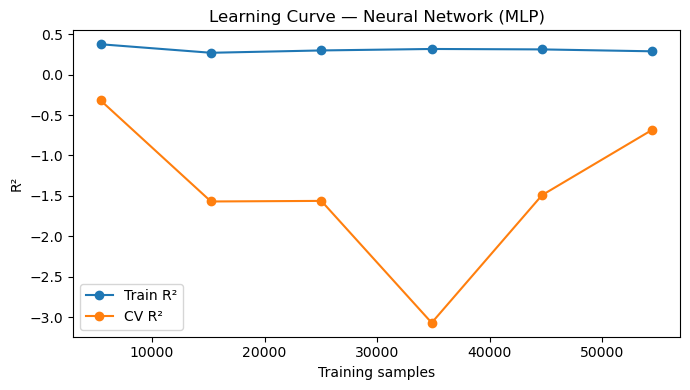

In [17]:
train_sizes, train_scores, val_scores = learning_curve(
    pipeline, X, y, cv=5, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 6)
)

train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

plt.figure(figsize=(7,4))
plt.plot(train_sizes, train_mean, marker='o', label='Train R²')
plt.plot(train_sizes, val_mean, marker='o', label='CV R²')
plt.xlabel("Training samples")
plt.ylabel("R²")
plt.title("Learning Curve — Neural Network (MLP)")
plt.legend()
plt.tight_layout()
plt.show()


## 12. Permutation Importance (on Test Set)

Permutation importance is **model-agnostic** and works with NNs.  
We report the top 20 features by importance (drop in R² when permuted).


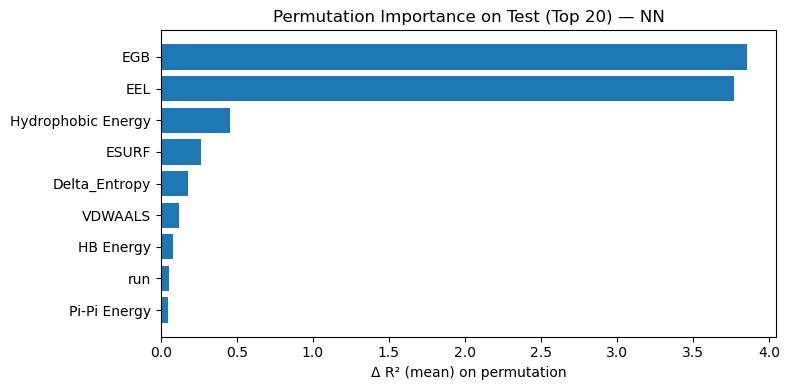

Saved permutation importances -> /Users/nakku/Desktop/ML-Protein-DNA-Binding-Affinity/ML-Protein-DNA-Binding-Affinity/tutorial notebooks/ML_NN_CV/nn_permutation_importance.csv


In [18]:
perm = permutation_importance(pipeline, X_test, y_test, scoring='r2', n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)
perm_imp = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': perm.importances_mean,
    'importance_std': perm.importances_std
}).sort_values('importance_mean', ascending=False)

topk = 20 if len(perm_imp) > 20 else len(perm_imp)
top_perm = perm_imp.head(topk)

plt.figure(figsize=(8, max(4, topk*0.3)))
plt.barh(top_perm['feature'][::-1], top_perm['importance_mean'][::-1])
plt.xlabel("Δ R² (mean) on permutation")
plt.title("Permutation Importance on Test (Top 20) — NN")
plt.tight_layout()
plt.show()

perm_path = OUTPUT_DIR / 'nn_permutation_importance.csv'
perm_imp.to_csv(perm_path, index=False)
print("Saved permutation importances ->", perm_path)


## 13. Partial Dependence (PDP)

Plot PDPs for the **top 3** permuted-important features (if available).  
Notes: PDPs for NNs can be noisy; interpret trends, not exact values.


Top 3 features for PDP: ['EGB', 'EEL', 'Hydrophobic Energy']


<Figure size 600x400 with 0 Axes>

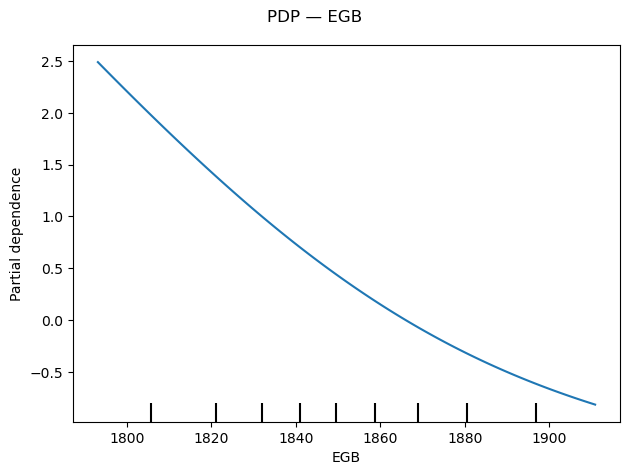

<Figure size 600x400 with 0 Axes>

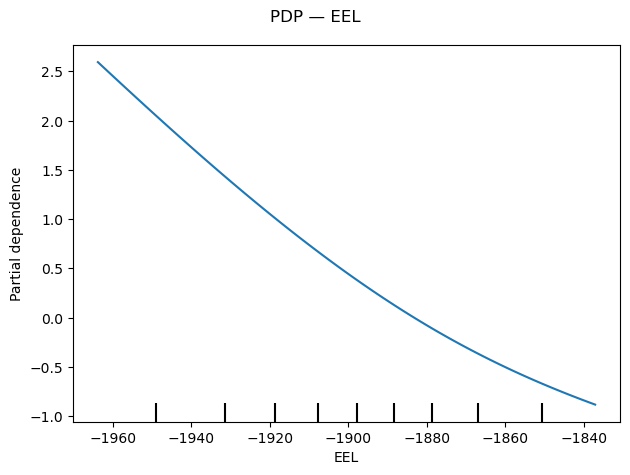

<Figure size 600x400 with 0 Axes>

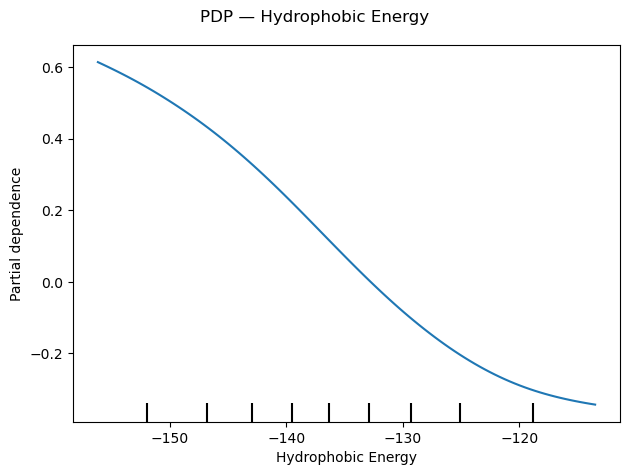

In [19]:
top3 = perm_imp['feature'].head(3).tolist()
print("Top 3 features for PDP:", top3)

for feat in top3:
    plt.figure(figsize=(6,4))
    try:
        PartialDependenceDisplay.from_estimator(pipeline, X_train, [feat])
        plt.suptitle(f"PDP — {feat}")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Skipping PDP for {feat}: {e}")


## 14. Randomized Hyperparameter Search (Quick Tune)

We run a lightweight `RandomizedSearchCV`. Increase `n_iter` for deeper searches.


In [ ]:
'''param_distributions = {
    'mlp__hidden_layer_sizes': [(64,), (128,), (256,), (128,64), (256,128), (256,128,64)],
    'mlp__alpha': np.logspace(-6, -2, 9),
    'mlp__learning_rate_init': np.logspace(-4, -2, 5),
    'mlp__batch_size': [32, 64, 128, 256],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['adam'],  # 'lbfgs' can work but no mini-batching; keep adam for consistency
    'mlp__early_stopping': [True],
    'mlp__n_iter_no_change': [10, 20, 30],
    'mlp__max_iter': [500]
}

search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=40,               # increase for more thorough search
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

search.fit(X_train, y_train)
print("Best params:", search.best_params_)
print("Best CV R²:", search.best_score_)

best_pipe = search.best_estimator_
y_pred_best = best_pipe.predict(X_test)
print("Best NN — Test R²:", r2_score(y_test, y_pred_best))
print("Best NN — Test RMSE:", math.sqrt(mean_squared_error(y_test, y_pred_best)))
print("Best NN — Test MAE:", mean_absolute_error(y_test, y_pred_best)))

best_model_path = OUTPUT_DIR / 'nn_model_best.pkl'
joblib.dump(best_pipe, best_model_path)
print("Saved best model ->", best_model_path)
'''

## 15. Save Final Artifacts & Metrics

We persist: baseline metrics, CV metrics, OOF metrics, holdout metrics, and configs.


In [ ]:
'''
# Save baseline (non-tuned) model as well
base_model_path = OUTPUT_DIR / 'nn_model_baseline.pkl'
joblib.dump(pipeline, base_model_path)

metrics = {
    'baseline_mean_predictor': {
        'r2': float(baseline_r2),
        'rmse': float(baseline_rmse),
        'mae': float(baseline_mae),
    },
    'baseline_cv': {
        'r2_mean': float(np.mean(cv_r2)),
        'rmse_mean': float(np.mean(np.sqrt(-cv_mse))),
        'mae_mean': float(np.mean(-cv_mae))
    },
    'holdout_baseline': {
        'r2': float(test_r2),
        'rmse': float(test_rmse),
        'mae': float(test_mae)
    },
    'oof': {
        'r2': float(oof_r2),
        'rmse': float(oof_rmse),
        'mae': float(oof_mae)
    }
}

metrics_path = OUTPUT_DIR / 'metrics.json'
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)

config = {
    'SEQUENCE_ID': SEQUENCE_ID,
    'LABEL_COL': LABEL_COL,
    'feature_cols': feature_cols,
    'RANDOM_STATE': RANDOM_STATE
}
config_path = OUTPUT_DIR / 'config.json'
with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)

print("Saved:")
print(" - Baseline NN pipeline ->", base_model_path)
print(" - Metrics ->", metrics_path)
print(" - Config ->", config_path)
'''

## 16. Next Steps / Ideas

- **GroupKFold** if sequences cluster (e.g., by protein family) to avoid leakage.
- Try **TransformedTargetRegressor** to standardize ΔΔG if the scale hampers training.
- Compare with **ElasticNet**, **GBM**, or **XGBoost/LightGBM** baselines.
- Add **uncertainty intervals** via conformal prediction on residuals.
- Try a **PyTorch** or **Keras** model with dropout, batch norm, and learning-rate schedules.
- Add **early stopping callbacks** and **checkpointing** (in deep learning frameworks).


## 17. Trial: Remove a Feature (EGB) and Re-Evaluate

In this exercise, we **exclude** the generalized Born component feature `EGB` and check how:
1) performance changes on the same hold-out test set, and  
2) **permutation importance** of other features shifts without `EGB`.

This helps diagnose feature redundancy and how much the model leans on a specific input.

> Note: For NNs, we use **permutation importance** (model-agnostic) as our “feature importance.”


In [20]:
# Prepare reduced feature set that excludes 'EGB'
TARGET_DROP = 'EGB'

# Verify whether 'EGB' exists; continue gracefully if not present
has_egb = TARGET_DROP in X.columns
print(f"'EGB' present in original X? {has_egb}")

if has_egb:
    # Build reduced design matrices for train/test using the same split as before
    X_train_red = X_train.drop(columns=[TARGET_DROP], errors='ignore')
    X_test_red  = X_test.drop(columns=[TARGET_DROP], errors='ignore')
    reduced_feature_cols = [c for c in feature_cols if c != TARGET_DROP]
else:
    # If 'EGB' wasn't present, this cell still runs and evaluates the same X for completeness
    X_train_red = X_train.copy()
    X_test_red  = X_test.copy()
    reduced_feature_cols = feature_cols.copy()

print("Reduced train shape:", X_train_red.shape, "| Reduced test shape:", X_test_red.shape)
print("Dropped columns:", [] if not has_egb else [TARGET_DROP])


'EGB' present in original X? True
Reduced train shape: (54432, 8) | Reduced test shape: (13608, 8)
Dropped columns: ['EGB']


In [21]:
# Refit an identical NN pipeline on the reduced features
from sklearn.base import clone

pipeline_red = clone(pipeline)  # same scaler + MLP settings as baseline
pipeline_red.fit(X_train_red, y_train)

# Evaluate on the same hold-out test set
y_pred_red = pipeline_red.predict(X_test_red)

test_r2_red   = r2_score(y_test, y_pred_red)
test_rmse_red = math.sqrt(mean_squared_error(y_test, y_pred_red))
test_mae_red  = mean_absolute_error(y_test, y_pred_red)

print(f"(No-EGB) Test — R²: {test_r2_red:.4f} | RMSE: {test_rmse_red:.4f} | MAE: {test_mae_red:.4f}")

# Side-by-side vs baseline (with EGB)
print("\nBaseline vs No-EGB (hold-out test)")
print(f"  R²   : {test_r2: .4f}  ->  {test_r2_red: .4f}  (Δ = {test_r2_red - test_r2:+.4f})")
print(f"  RMSE : {test_rmse: .4f}  ->  {test_rmse_red: .4f}  (Δ = {test_rmse_red - test_rmse:+.4f})")
print(f"  MAE  : {test_mae: .4f}  ->  {test_mae_red: .4f}  (Δ = {test_mae_red - test_mae:+.4f})")


(No-EGB) Test — R²: 0.1967 | RMSE: 0.7469 | MAE: 0.5912

Baseline vs No-EGB (hold-out test)
  R²   :  0.2098  ->   0.1967  (Δ = -0.0131)
  RMSE :  0.7408  ->   0.7469  (Δ = +0.0061)
  MAE  :  0.5851  ->   0.5912  (Δ = +0.0061)


### Permutation importance without EGB

We recompute permutation importance on the test set using the **reduced** feature matrix.
Then we compare it to the baseline importances (with EGB) to see which features "picked up the slack."


In [22]:
# Permutation importance on the reduced model
perm_red = permutation_importance(
    pipeline_red, X_test_red, y_test,
    scoring='r2', n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1
)

perm_imp_red = pd.DataFrame({
    'feature': X_test_red.columns,
    'importance_mean_noEGB': perm_red.importances_mean,
    'importance_std_noEGB': perm_red.importances_std
}).sort_values('importance_mean_noEGB', ascending=False)

# If we computed perm_imp earlier (baseline), merge to compare; otherwise just show reduced
if 'perm_imp' in globals():
    comp = perm_imp[['feature','importance_mean']].rename(
        columns={'importance_mean':'importance_mean_baseline'}
    ).merge(
        perm_imp_red[['feature','importance_mean_noEGB']],
        on='feature', how='outer'
    )
    comp['delta_noEGB_minus_baseline'] = comp['importance_mean_noEGB'] - comp['importance_mean_baseline']
    comp = comp.sort_values('delta_noEGB_minus_baseline', ascending=False)
    display(comp.head(20))
else:
    print("Baseline permutation importance table (perm_imp) not found; showing reduced importances only.")
    display(perm_imp_red.head(20))


,feature,importance_mean_baseline,importance_mean_noEGB,delta_noEGB_minus_baseline
3,ESURF,0.262265,0.632664,0.370398
2,Hydrophobic Energy,0.455815,0.667324,0.211509
4,Delta_Entropy,0.180966,0.235646,0.054680
7,run,0.052302,0.071579,0.019278
6,HB Energy,0.080355,0.093101,0.012746
8,Pi-Pi Energy,0.046547,0.054843,0.008296
5,VDWAALS,0.117394,0.079821,-0.037573
1,EEL,3.768858,0.056143,-3.712714
0,EGB,3.855133,NaN,NaN


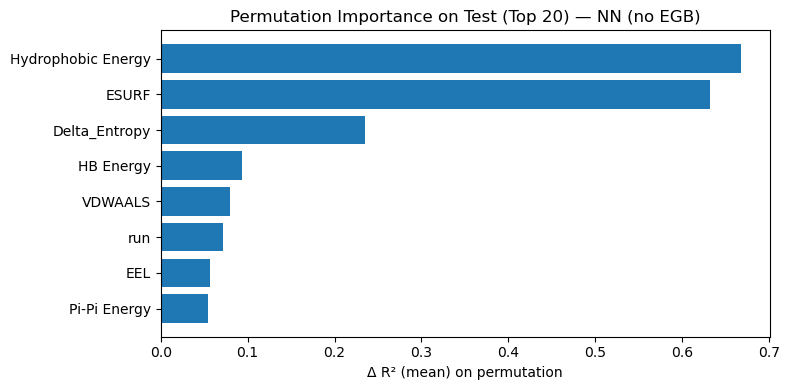

In [23]:
# Plot top-20 reduced permutation importances
topk = 20 if len(perm_imp_red) > 20 else len(perm_imp_red)
top_perm_red = perm_imp_red.head(topk)

plt.figure(figsize=(8, max(4, topk*0.3)))
plt.barh(top_perm_red['feature'][::-1], top_perm_red['importance_mean_noEGB'][::-1])
plt.xlabel("Δ R² (mean) on permutation")
plt.title("Permutation Importance on Test (Top 20) — NN (no EGB)")
plt.tight_layout()
plt.show()


### (Optional) PDPs after removing EGB

We can replot PDPs for the **top 3** features from the no-EGB permutation importance to see if
their marginal effects changed.


Top 3 features (no EGB) for PDP: ['Hydrophobic Energy', 'ESURF', 'Delta_Entropy']


<Figure size 600x400 with 0 Axes>

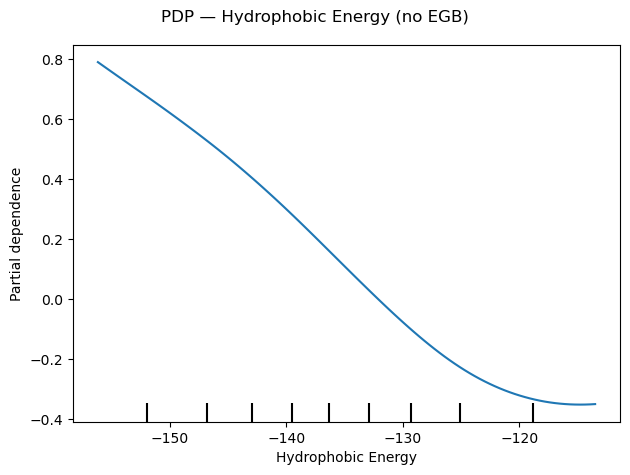

<Figure size 600x400 with 0 Axes>

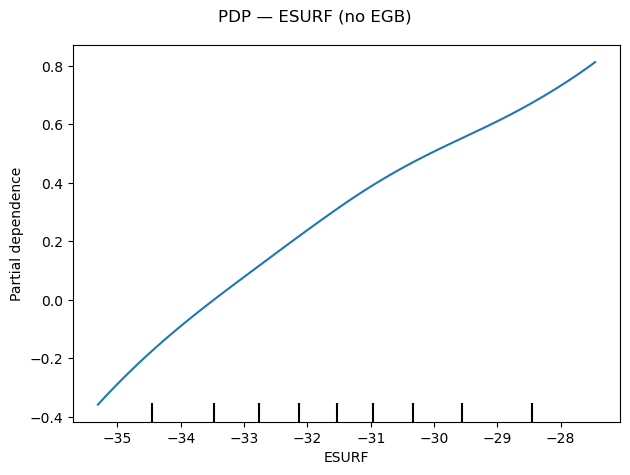

<Figure size 600x400 with 0 Axes>

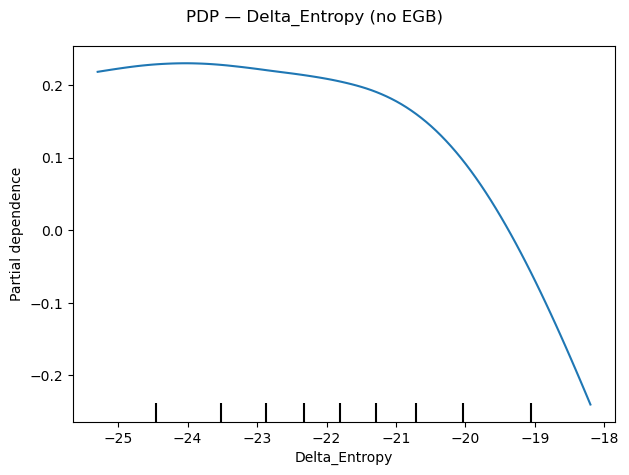

In [24]:
top3_red = perm_imp_red['feature'].head(3).tolist()
print("Top 3 features (no EGB) for PDP:", top3_red)

for feat in top3_red:
    plt.figure(figsize=(6,4))
    try:
        PartialDependenceDisplay.from_estimator(pipeline_red, X_train_red, [feat])
        plt.suptitle(f"PDP — {feat} (no EGB)")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Skipping PDP for {feat}: {e}")
